In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import time
import seaborn as sns
sns.set()

In [2]:
# Global parameters for easy access. Ideally these would be the same but that's not a requirement.
NUMBER_OF_CLUSTERS = 10
NUMBER_OF_CATEGORIES = 5

In [3]:
pd.set_option('display.max_columns', None)
#Load data and keep index id as "ind_id"
data = pd.read_csv("invoice_data_with_features.csv", sep=",", index_col=0)

In [4]:
data['TransDate'] = pd.to_datetime(data['TransDate'])
data['DueDate'] = pd.to_datetime(data['DueDate'])
data['SettleTransDate'] = pd.to_datetime(data['SettleTransDate'])
data['Customer_NKey'] = data['Customer_NKey'].astype('category')
data['last_invoice_paid_status'] = data['last_invoice_paid_status'].astype('category')
data['Invoice'] = data['Invoice'].astype('category')
data['is_late'] = data['is_late'].astype('category')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48767 entries, 1369 to 54573
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ind_id                         48767 non-null  int64         
 1   Customer_NKey                  48767 non-null  category      
 2   Invoice                        48767 non-null  category      
 3   TransDate                      48767 non-null  datetime64[ns]
 4   DueDate                        48767 non-null  datetime64[ns]
 5   SettleTransDate                48767 non-null  datetime64[ns]
 6   AmountEUR                      48767 non-null  float64       
 7   days_late                      48767 non-null  int64         
 8   is_late                        48767 non-null  category      
 9   days_between_created_and_paid  48767 non-null  int64         
 10  days_between_created_and_due   48767 non-null  int64         
 11  total_number

## Mini-exploration

In [6]:
data.groupby("Customer_NKey").count()

,ind_id,Invoice,TransDate,DueDate,SettleTransDate,AmountEUR,days_late,is_late,days_between_created_and_paid,days_between_created_and_due,total_number_invoices,total_sum_invoices,average_days_late_and_early,average_days_late_total,average_days_early_total,last_invoice_paid_status,total_paid_invoices,sum_amount_paid_invoices,total_invoices_late,total_invoices_early,sum_amount_late_invoices,sum_amount_early_invoices,total_outstanding_invoices,total_outstanding_late,sum_total_outstanding,sum_late_outstanding,average_days_late,average_days_early,average_days_outstanding_late,std_days_late,std_days_early,std_days_outstanding_late,ratio_1_late,ratio_1_early,ratio_2_late,ratio_2_early,ratio_3_late,ratio_4_late
Customer_NKey,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
COCA_10046,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544,544
COCA_10101,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236,236
COCA_10118,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556
COCA_10129,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408
COCA_10132,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136,1136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SODA_10281,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268
SODA_11423,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415,415
SODA_11479,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54


In [7]:
def visualize_plots(dataset, column_name):
    fig, ax = plt.subplots(1,1)
    sns.histplot(data=dataset, x="days_late", kde=True)
    ax[0] =  sns.histplot(
        data=dataset,
        x=column_name,
        kde=True)
    column = f"{column_name}"
    dataset.column.plot.hist(bins=50)

<AxesSubplot:>

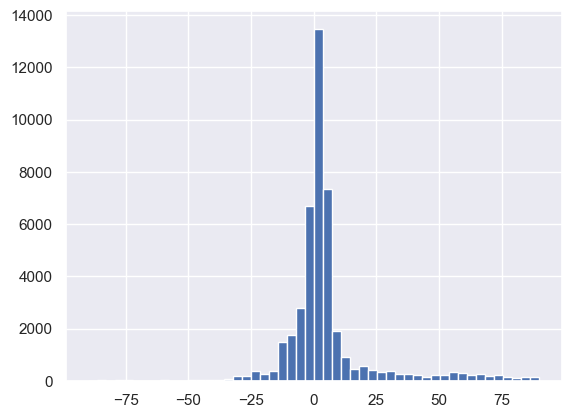

In [8]:
data[(data['days_late']>=(-90) ) & (data['days_late']<=(90))]["days_late"].hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

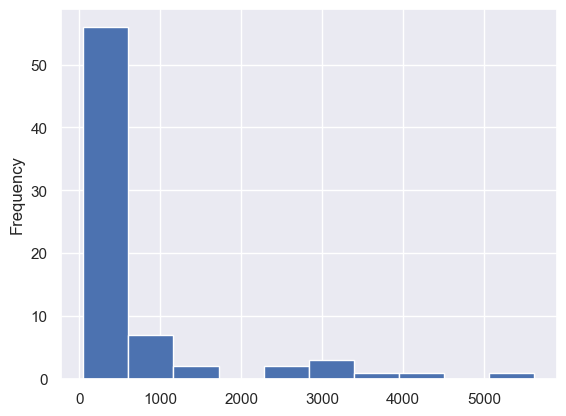

In [9]:
data.groupby("Customer_NKey").count().ind_id.plot.hist()

<AxesSubplot:ylabel='Density'>

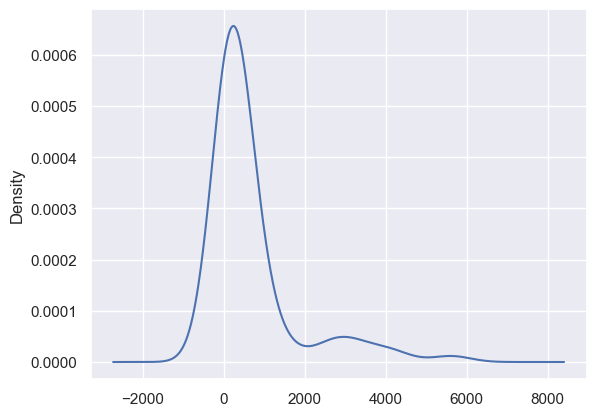

In [10]:
data.groupby("Customer_NKey").count().ind_id.plot.density()

<AxesSubplot:xlabel='Customer_NKey'>

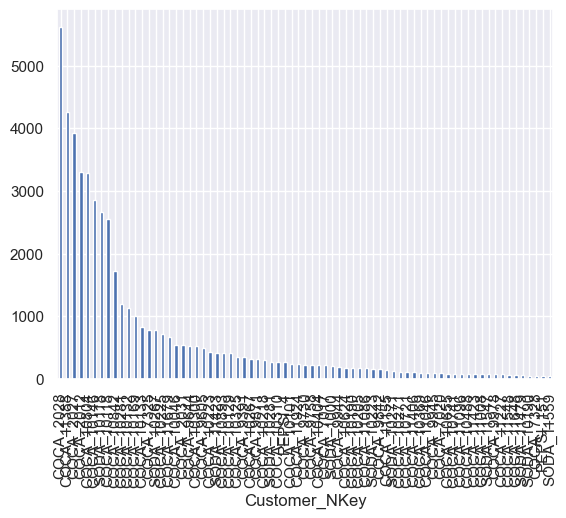

In [11]:
data.groupby("Customer_NKey").count().ind_id.sort_values(ascending=False).plot.bar()

In [12]:
data.describe()

,ind_id,AmountEUR,days_late,days_between_created_and_paid,days_between_created_and_due,total_number_invoices,total_sum_invoices,average_days_late_and_early,average_days_late_total,average_days_early_total,total_paid_invoices,sum_amount_paid_invoices,total_invoices_late,total_invoices_early,sum_amount_late_invoices,sum_amount_early_invoices,total_outstanding_invoices,total_outstanding_late,sum_total_outstanding,sum_late_outstanding,average_days_late,average_days_early,average_days_outstanding_late,std_days_late,std_days_early,std_days_outstanding_late,ratio_1_late,ratio_1_early,ratio_2_late,ratio_2_early,ratio_3_late,ratio_4_late
count,48767.000000,4.876700e+04,48767.000000,48767.000000,48767.000000,48767.000000,4.876700e+04,48767.000000,48767.000000,48767.000000,48767.000000,4.876700e+04,48767.000000,48767.000000,4.876700e+04,4.876700e+04,48767.000000,48767.000000,4.876700e+04,4.876700e+04,48767.000000,48767.000000,48767.000000,48767.000000,48767.000000,48767.000000,48767.000000,48767.000000,48767.000000,48767.000000,48767.000000,48767.000000
mean,28507.092891,1.835151e+04,22.003342,75.080177,53.076835,1238.953083,2.803026e+07,13.635326,15.617477,1.982151,1118.771485,2.641540e+07,666.813562,451.957922,1.638018e+07,1.003522e+07,120.181598,43.099678,1.614868e+06,6.289975e+05,21.544080,4.727864,23.494714,18.657535,5.328153,13.680504,0.565523,0.426665,0.558225,0.433962,0.193360,0.192435
std,15328.665139,2.653259e+04,57.447078,67.694002,27.903609,1242.868459,3.684476e+07,28.428156,27.517649,3.633653,1119.671376,3.595370e+07,896.473535,598.784239,2.494150e+07,1.495992e+07,197.891545,97.360919,2.590618e+06,1.657483e+06,33.647776,6.557268,74.722434,36.584467,4.855985,52.065433,0.313714,0.311980,0.308144,0.306565,0.269723,0.270557
min,1369.000000,4.190000e+00,-180.000000,0.000000,0.000000,0.000000,0.000000e+00,-83.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16150.500000,5.382640e+03,-1.000000,31.000000,30.000000,219.000000,2.837117e+06,0.000000,1.484375,0.175439,196.000000,2.613533e+06,86.000000,24.000000,8.271921e+05,9.528831e+05,6.000000,0.000000,7.937380e+04,0.000000e+00,4.964427,0.750000,0.000000,5.373398,2.385163,0.000000,0.284054,0.134194,0.283953,0.152724,0.000000,0.000000
50%,28973.000000,1.740074e+04,2.000000,59.000000,53.000000,767.000000,1.117065e+07,2.986497,3.551724,0.542857,699.000000,9.819195e+06,276.000000,215.000000,5.162872e+06,3.173699e+06,25.000000,1.000000,6.126978e+05,4.668260e+03,6.712704,3.000000,1.000000,9.177542,3.799145,0.000000,0.596258,0.397661,0.629097,0.359005,0.028571,0.024934
75%,41420.500000,2.196653e+04,9.000000,95.000000,90.000000,2023.000000,3.802501e+07,9.796970,11.090909,2.454091,1807.000000,3.457424e+07,885.000000,582.000000,2.068329e+07,1.148266e+07,112.000000,9.000000,1.932324e+06,1.957315e+05,18.916667,6.429508,19.571429,17.117721,6.577785,8.218735,0.860465,0.710365,0.835095,0.712750,0.350711,0.351086
max,54573.000000,1.128040e+06,2302.000000,2316.000000,180.000000,5498.000000,1.339829e+08,119.785737,120.462576,83.000000,5104.000000,1.304974e+08,4522.000000,3073.000000,9.722087e+07,7.851200e+07,1058.000000,635.000000,2.088743e+07,1.978793e+07,275.666667,83.000000,1048.000000,473.138810,58.689863,745.997654,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Creating categories

In [13]:
def categorize(x, info):

    if info == "number":
        if x<(-7):
            return(0)
        #### ***How to seperate values around 0? Depends. This can be changed depending on the need. 
        #Change if needed
        #### ***FOR NOW CONSIDERING 0-7 days early and late as one category, seperating them at 0 might not be best
        #Change if needed
        elif x in range(-7, 1):
            return(1)
        elif x in range(1, 8):
            return(1)
        #### 
        elif x in range(8, 31):
            return(2)
        elif x in range(31, 91):
            return(3)
        else: 
            return(4)
        
    if info ==  "label":
        return("Disabled for testing")
# Use this when the optimal categories are decided
    
#         if x<(-90):
#             return('Over 90 D early')
#         elif x in range(-90,-60):
#             return('61-90 D early')
#         elif x in range(-60,-30):
#             return('31-60 D early')
#         elif x in range(-30,-7):
#             return('8-30 D early')
#         #### ***FOR NOW CONSIDERING 0-7 days early and late as one category, seperating them at 0 might not be best
#         #Change if needed
#         elif x in range(-7, 1):
#             return('-7 to 0 days')
#         elif x in range(1, 8):
#             return('1 to 7 days')
#         #### 
#         elif x in range(8, 31):
#             return('8-30 D late')
#         elif x in range(31, 61):
#             return('31-60 D late')
#         elif x in range(61, 91):
#             return('61-90 D late')
#         else: 
#             return('Over 90 D late')

In [14]:
## Categorize every invoice

In [15]:
#Get category labels
data["category"] = data.days_late.apply(lambda x: categorize(x, "label"))

In [16]:
#Get category numbers
data["category_no"] = data.days_late.apply(lambda x: categorize(x, "number"))

## One-hot coding categorical features

In [17]:
#Getting dummies for feature #10 last_invoice_paid_status
data = pd.get_dummies(data, columns=['last_invoice_paid_status'], prefix = ['last_invoice_paid_status'])

## Seperating train, validation & test data

### Based on recency

In [18]:
#CHANGE PERCENTAGES OF TRAIN/VAL/SPLIT HERE
#Splitting the dataframe (must be already sorted by date)
def train_validate_test_split(df, train_percent=.7, validate_percent=.15):
    n = len(df.index)
    train_end = int(train_percent * n)
    validate_end = int(validate_percent * n) + train_end
    train = df.iloc[:train_end]
    validate = df.iloc[train_end:validate_end]
    test = df.iloc[validate_end:]
    return train, validate, test

In [19]:
def split_dataframes(dataset):
    list_of_client_ids = dataset["Customer_NKey"].unique()
    train_df_list = []
    validate_df_list = []
    test_df_list = []
    for client_id in list_of_client_ids:
        dataframe = dataset[dataset["Customer_NKey"] == client_id].sort_values(by="TransDate", ascending=True)
        train_df, val_df, test_df = train_validate_test_split(dataframe)
        train_df_list.append(train_df)
        validate_df_list.append(val_df)
        test_df_list.append(test_df)
    
    df_train_final = pd.concat(train_df_list)
    df_val_final = pd.concat(validate_df_list)
    df_test_final = pd.concat(test_df_list)
    return df_train_final, df_val_final, df_test_final

In [20]:
# Splitting data into train, validate, and test dataframes. 
# Splitting based: percentage (%) of most recent invoices per each customer
train_df, validate_df, test_df = split_dataframes(data)
train_val_combined_df = pd.concat([train_df, validate_df])

In [21]:
#Compare
train_df.describe()

,ind_id,AmountEUR,days_late,days_between_created_and_paid,days_between_created_and_due,total_number_invoices,total_sum_invoices,average_days_late_and_early,average_days_late_total,average_days_early_total,total_paid_invoices,sum_amount_paid_invoices,total_invoices_late,total_invoices_early,sum_amount_late_invoices,sum_amount_early_invoices,total_outstanding_invoices,total_outstanding_late,sum_total_outstanding,sum_late_outstanding,average_days_late,average_days_early,average_days_outstanding_late,std_days_late,std_days_early,std_days_outstanding_late,ratio_1_late,ratio_1_early,ratio_2_late,ratio_2_early,ratio_3_late,ratio_4_late,category_no,last_invoice_paid_status_-1.0,last_invoice_paid_status_0.0,last_invoice_paid_status_1.0
count,34102.000000,3.410200e+04,34102.000000,34102.000000,34102.000000,34102.000000,3.410200e+04,34102.000000,34102.000000,34102.000000,34102.000000,3.410200e+04,34102.000000,34102.000000,3.410200e+04,3.410200e+04,34102.000000,34102.000000,3.410200e+04,3.410200e+04,34102.000000,34102.000000,34102.000000,34102.000000,34102.000000,34102.000000,34102.000000,34102.000000,34102.000000,34102.000000,34102.000000,34102.000000,34102.000000,34102.000000,34102.000000,34102.000000
mean,29367.373497,1.876840e+04,17.352648,68.227787,50.875139,866.498329,2.165305e+07,12.161674,14.112045,1.950371,768.569439,2.038099e+07,439.156853,329.412586,1.266635e+07,7.714639e+06,97.928890,32.420327,1.272055e+06,4.461503e+05,20.199399,4.762205,21.626110,17.721716,5.207596,11.385615,0.557890,0.430938,0.555222,0.433606,0.187370,0.187500,1.442643,0.011172,0.944578,0.044250
std,15636.314163,2.988512e+04,44.517145,55.612038,27.583557,867.219580,3.232172e+07,25.676164,24.833262,3.400631,765.573069,3.179991e+07,569.414431,427.177427,2.200893e+07,1.223785e+07,162.286869,71.432696,1.832550e+06,1.024565e+06,32.840248,6.846893,67.810713,38.443750,4.979224,37.487658,0.310992,0.308703,0.307896,0.305682,0.266129,0.267945,1.056056,0.105109,0.228805,0.205652
min,1369.000000,4.190000e+00,-97.000000,0.000000,0.000000,0.000000,0.000000e+00,-83.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16548.250000,5.741260e+03,-1.000000,30.000000,30.000000,153.000000,1.976442e+06,0.000000,1.484375,0.200000,133.000000,1.790013e+06,58.000000,13.000000,5.209680e+05,5.658870e+05,6.000000,0.000000,7.385461e+04,0.000000e+00,4.685588,0.750000,0.000000,4.935426,2.356981,0.000000,0.280721,0.164557,0.280042,0.164905,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,29830.500000,1.728000e+04,2.000000,58.000000,45.000000,537.000000,7.781990e+06,2.961538,3.481527,0.572464,471.500000,6.953812e+06,195.000000,153.000000,3.642389e+06,2.186564e+06,21.000000,1.000000,5.272479e+05,3.680530e+03,6.749365,3.000000,1.000000,8.980284,3.286019,0.000000,0.585706,0.400000,0.626281,0.360695,0.026316,0.023142,1.000000,0.000000,1.000000,0.000000
75%,42983.750000,2.143292e+04,9.000000,94.000000,60.000000,1413.000000,2.539084e+07,9.445455,10.428571,2.492375,1315.500000,2.252832e+07,583.750000,546.000000,1.303342e+07,7.808967e+06,91.000000,7.000000,1.557283e+06,1.484914e+05,18.500000,6.283310,17.333333,15.913235,6.888925,5.912205,0.823956,0.712376,0.816112,0.713962,0.339844,0.336575,2.000000,0.000000,1.000000,0.000000
max,54213.000000,1.128040e+06,2302.000000,2316.000000,120.000000,3883.000000,1.230926e+08,111.133465,111.563025,83.000000,3442.000000,1.207180e+08,2860.000000,2104.000000,8.744145e+07,5.727650e+07,781.000000,397.000000,9.079803e+06,4.724690e+06,275.666667,83.000000,853.000000,473.138810,58.689863,535.279833,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000


In [22]:
test_df.describe()

,ind_id,AmountEUR,days_late,days_between_created_and_paid,days_between_created_and_due,total_number_invoices,total_sum_invoices,average_days_late_and_early,average_days_late_total,average_days_early_total,total_paid_invoices,sum_amount_paid_invoices,total_invoices_late,total_invoices_early,sum_amount_late_invoices,sum_amount_early_invoices,total_outstanding_invoices,total_outstanding_late,sum_total_outstanding,sum_late_outstanding,average_days_late,average_days_early,average_days_outstanding_late,std_days_late,std_days_early,std_days_outstanding_late,ratio_1_late,ratio_1_early,ratio_2_late,ratio_2_early,ratio_3_late,ratio_4_late,category_no,last_invoice_paid_status_-1.0,last_invoice_paid_status_0.0,last_invoice_paid_status_1.0
count,7383.000000,7383.000000,7383.000000,7383.000000,7383.000000,7383.000000,7.383000e+03,7383.000000,7383.000000,7383.000000,7383.000000,7.383000e+03,7383.000000,7383.000000,7.383000e+03,7.383000e+03,7383.000000,7383.000000,7.383000e+03,7.383000e+03,7383.000000,7383.000000,7383.000000,7383.000000,7383.000000,7383.000000,7383.000000,7383.000000,7383.000000,7383.000000,7383.000000,7383.000000,7383.000000,7383.0,7383.000000,7383.000000
mean,26005.939049,18637.101308,38.279832,97.146011,58.866179,2279.978329,4.550621e+07,17.404335,19.485834,2.081499,2093.220236,4.266128e+07,1298.922931,794.297305,2.626902e+07,1.639226e+07,186.758093,76.227550,2.844924e+06,1.339616e+06,25.140187,4.702845,28.118812,21.220888,5.630115,19.726904,0.583659,0.416341,0.564293,0.435707,0.205903,0.201836,1.524177,0.0,0.945551,0.054449
std,14148.525648,16995.466845,90.509427,100.078910,28.677954,1640.371048,4.353957e+07,34.219940,33.143826,4.112122,1472.818973,4.197595e+07,1343.829848,875.538890,2.971240e+07,1.982538e+07,285.096044,161.612263,4.492180e+06,3.229050e+06,35.857634,5.863986,90.517699,32.374485,4.493826,78.030134,0.322070,0.322070,0.310050,0.310050,0.292354,0.290274,1.236218,0.0,0.226918,0.226918
min,1938.000000,25.960000,-180.000000,0.000000,1.000000,42.000000,9.598780e+03,-54.936170,0.000000,0.000000,35.000000,9.097340e+03,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,15089.500000,5595.285000,-1.000000,35.000000,31.000000,619.000000,7.699722e+06,-0.270550,1.470588,0.100300,602.000000,7.569666e+06,222.000000,96.000000,2.736682e+06,1.596501e+06,7.000000,0.000000,8.882557e+04,0.000000e+00,5.447425,0.800000,0.000000,6.972470,2.775401,0.000000,0.286162,0.117528,0.282793,0.136347,0.000000,0.000000,1.000000,0.0,1.000000,0.000000
50%,26175.000000,18656.490000,3.000000,64.000000,60.000000,2481.000000,3.824123e+07,3.643939,4.134146,0.416327,2425.000000,3.664488e+07,691.000000,582.000000,1.188664e+07,8.253035e+06,43.000000,1.000000,8.734577e+05,3.429200e+03,6.988720,2.965116,1.000000,11.533505,4.175964,0.000000,0.647619,0.352381,0.651222,0.348778,0.017544,0.012847,1.000000,0.0,1.000000,0.000000
75%,37364.500000,26984.045000,10.000000,97.000000,90.000000,3556.500000,7.437021e+07,10.399072,11.971429,2.316990,3071.000000,6.281938e+07,2253.000000,974.000000,3.810133e+07,2.902718e+07,390.000000,14.000000,2.977106e+06,2.501311e+05,23.925614,7.205176,25.200000,26.863912,5.880827,12.727922,0.882472,0.713838,0.863653,0.717207,0.355330,0.380629,2.000000,0.0,1.000000,0.000000
max,54573.000000,405933.060000,652.000000,682.000000,180.000000,5498.000000,1.339829e+08,119.785737,120.462576,59.500000,5104.000000,1.304974e+08,4522.000000,3073.000000,9.722087e+07,7.851200e+07,1058.000000,635.000000,2.088743e+07,1.978793e+07,133.547009,68.207317,1020.000000,228.563989,25.009961,610.553028,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,0.0,1.000000,1.000000


### Late days between -90 and 90 distribution comparison

<AxesSubplot:>

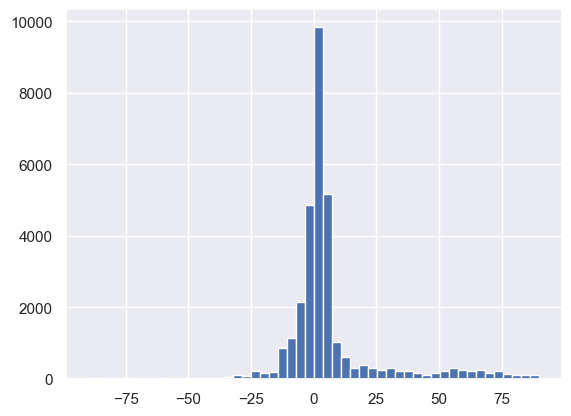

In [23]:
train_df[(train_df['days_late']>=(-90) ) & (train_df['days_late']<=(90))]["days_late"].hist(bins=50)

<AxesSubplot:>

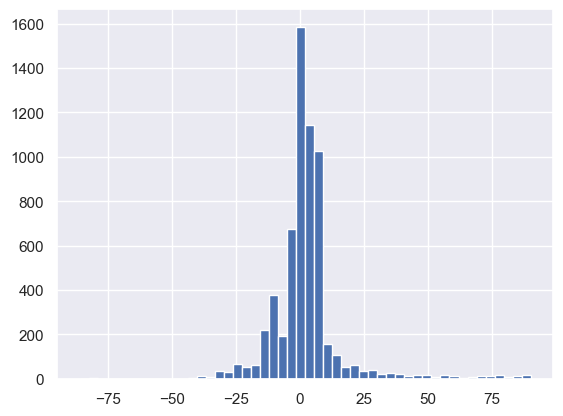

In [24]:
test_df[(test_df['days_late']>=(-90) ) & (test_df['days_late']<=(90))]["days_late"].hist(bins=50)

### Density comparison

<AxesSubplot:ylabel='Density'>

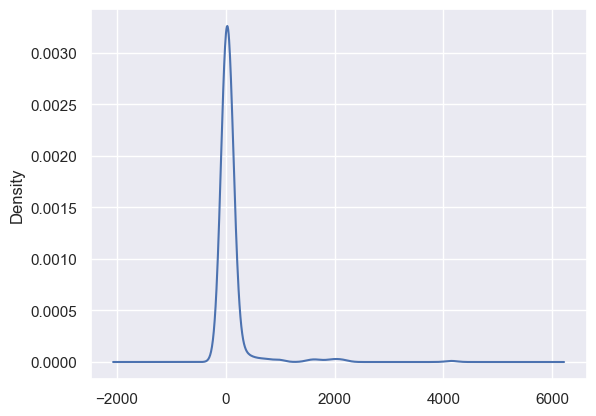

In [25]:
train_df["days_late"].value_counts().plot.density()

<AxesSubplot:ylabel='Density'>

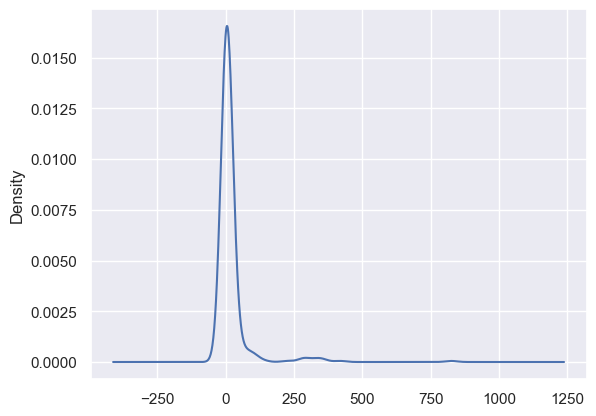

In [26]:
test_df["days_late"].value_counts().plot.density()

# Preparation for training

In [27]:
#For training the models
import xgboost as xgb
import sklearn.metrics as sm
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression,Ridge,Lasso, LogisticRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,cross_val_predict,cross_validate,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score,max_error,r2_score,median_absolute_error,mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler,normalize,StandardScaler,RobustScaler, Normalizer
from sklearn.metrics import f1_score, accuracy_score
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier


In [28]:
# #Optional (depending if training based on clusters or clientID)
# #Getting dummies for feature #10 last_invoice_paid_status
# data = pd.get_dummies(data, columns=['Customer_NKey'], prefix = ['Customer'])

In [29]:
#Categorical values for training
categorical_cols = ['last_invoice_paid_status_-1.0','last_invoice_paid_status_0.0', 'last_invoice_paid_status_1.0']
# Continious/ordinal  values for training
cont_cols = ['AmountEUR','days_between_created_and_due',
       'total_number_invoices', 'total_sum_invoices',
       'average_days_late_and_early', 'average_days_late_total',
       'average_days_early_total', 'total_paid_invoices',
       'sum_amount_paid_invoices', 'total_invoices_late',
       'total_invoices_early', 'sum_amount_late_invoices',
       'sum_amount_early_invoices', 'total_outstanding_invoices',
       'total_outstanding_late', 'sum_total_outstanding',
       'sum_late_outstanding', 'average_days_late', 'average_days_early',
       'average_days_outstanding_late', 'std_days_late', 'std_days_early',
       'std_days_outstanding_late', 'ratio_1_late', 'ratio_1_early',
       'ratio_2_late', 'ratio_2_early', 'ratio_3_late', 'ratio_4_late']

#Combined list
column_names_for_training = categorical_cols + cont_cols

## Clustering invoices and clients

In [30]:
# # #Test different numbers of clusters (for exploration purpose)
# # #This is commented out so it wouldn't run every time. 

# from sklearn.cluster import KMeans
# # Finding optimal number of clusters using elbow method 
# minmaxscaler = MinMaxScaler()
# kmeans_df_train = minmaxscaler.fit_transform(train_val_combined_df[column_names_for_training])
# # Finding optimal K value
# possible_K_values = [i for i in range(2,40)]
# # Inertia list
# inertia = []
# for each_value in possible_K_values:
#     # iterate through, taking each value from 
#     KMeans_model = KMeans(n_clusters=each_value, random_state=1)
#     # fit it
#     KMeans_model.fit(kmeans_df_train)
#     # append the inertia to our array
#     inertia.append(KMeans_model.inertia_)
    
# plt.plot(possible_K_values, inertia)
# plt.title('The Elbow Method')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia')
# plt.show()

In [31]:
#Fitting KMeans predefined number of clusters. 10 would be reasonable, but can be changed. 
from sklearn.cluster import KMeans
minmaxscaler = MinMaxScaler()
kmeans_df_train = minmaxscaler.fit_transform(train_val_combined_df[column_names_for_training])
KMeans_model = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=1)
# fit it
KMeans_model.fit(kmeans_df_train)

KMeans(n_clusters=10, random_state=1)

In [32]:
# Assigning clusters to each invoice
k_means_df = train_val_combined_df.copy(deep=True)
k_means_df["invoice_cluster"] = KMeans_model.labels_

In [33]:
# Assigning clusters to each customer
customer_clusters = k_means_df.groupby("Customer_NKey")["invoice_cluster"].agg(lambda x: x.value_counts().index[0])

In [34]:
def add_cluster_labels(dataset, customerclusters):
    dataframe = dataset.copy(deep=True)
    customer_clabels = customerclusters.to_dict()
    for client_id in customer_clabels:
        dataframe[dataframe["Customer_NKey"] == client_id]
        dataframe.loc[dataframe["Customer_NKey"] == client_id, 'client_cluster'] = customer_clabels[client_id]
        dataframe["client_cluster"] = dataframe["client_cluster"].apply("int64")
        
        
    return dataframe

In [35]:
# Add customer clusters to each dataset
train_df = add_cluster_labels(train_df, customer_clusters)
validate_df = add_cluster_labels(validate_df, customer_clusters)
test_df = add_cluster_labels(test_df, customer_clusters)
train_val_combined_df = add_cluster_labels(train_val_combined_df, customer_clusters)

## Seperate train, val and test dataframes for cluster based or clientID based training

### For clusters

In [36]:
cluster_train_df = train_df.copy(deep=True)
cluster_validate_df = validate_df.copy(deep=True)
cluster_test_df = test_df.copy(deep=True)
cluster_train_val_combined_df = train_val_combined_df.copy(deep=True)

In [37]:
#Getting dummies for CLIENT CLUSTERS
cluster_train_df = pd.get_dummies(cluster_train_df, columns=['client_cluster'], prefix = ['client_cluster'])
cluster_validate_df = pd.get_dummies(cluster_validate_df, columns=['client_cluster'], prefix = ['client_cluster'])
cluster_test_df = pd.get_dummies(cluster_test_df, columns=['client_cluster'], prefix = ['client_cluster'])
cluster_train_val_combined_df = pd.get_dummies(cluster_train_val_combined_df, columns=['client_cluster'], prefix = ['client_cluster'])

In [38]:
#Creating a list of col_names of dummy variables for client clusters
colnames_client_clusters = list(cluster_train_df.columns[-(NUMBER_OF_CLUSTERS):])

In [39]:
cols_for_cluster_training = categorical_cols + cont_cols + colnames_client_clusters

In [40]:
#Creating x and y data
### Train
#for linear models
cluster_train_df_linear_x = cluster_train_df[cols_for_cluster_training]
cluster_train_df_linear_y = cluster_train_df["days_late"]
#for logistic models
cluster_train_df_logistic_x = cluster_train_df[cols_for_cluster_training]
cluster_train_df_logistic_y = cluster_train_df["category_no"]

In [41]:
#Creating x and y data
### Validate
#for linear models
cluster_validate_df_linear_x = cluster_validate_df[cols_for_cluster_training]
cluster_validate_df_linear_y = cluster_validate_df["days_late"]
#for logistic models
cluster_validate_df_logistic_x = cluster_validate_df[cols_for_cluster_training]
cluster_validate_df_logistic_y = cluster_validate_df["category_no"]

In [42]:
#Creating x and y data
### Validate
#for linear models
cluster_test_df_linear_x = cluster_test_df[cols_for_cluster_training]
cluster_test_df_linear_y = cluster_test_df["days_late"]
#for logistic models
cluster_test_df_logistic_x = cluster_test_df[cols_for_cluster_training]
cluster_test_df_logistic_y = cluster_test_df["category_no"]

In [43]:
#Creating x and y data
### Train_val combined (just in case for CV)
#for linear models
cluster_train_val_combined_linear_x = cluster_train_val_combined_df[cols_for_cluster_training]
cluster_train_val_combined_linear_y = cluster_train_val_combined_df["days_late"]
#for logistic models
cluster_train_val_combined_logistic_x = cluster_train_val_combined_df[cols_for_cluster_training]
cluster_train_val_combined_logistic_y = cluster_train_val_combined_df["category_no"]

### For Client-ID based

In [44]:
clientid_train_df = train_df.copy(deep=True)
clientid_validate_df = validate_df.copy(deep=True)
clientid_test_df = test_df.copy(deep=True)
clientid_train_val_combined_df = train_val_combined_df.copy(deep=True)

In [45]:
#Getting dummies for CLIENT ID
clientid_train_df = pd.get_dummies(clientid_train_df, columns=['Customer_NKey'], prefix = ['customer'])
clientid_validate_df = pd.get_dummies(clientid_validate_df, columns=['Customer_NKey'], prefix = ['customer'])
clientid_test_df = pd.get_dummies(clientid_test_df, columns=['Customer_NKey'], prefix = ['customer'])
clientid_train_val_combined_df = pd.get_dummies(clientid_train_val_combined_df, columns=['Customer_NKey'], prefix = ['customer'])

In [46]:
#Creating a list of col_names of dummy variables for client IDs
colnames_client_ids = colnames_client_ids = list(clientid_train_df.columns[-(train_df["Customer_NKey"].nunique()):])

In [47]:
cols_for_cliendid_training = categorical_cols + cont_cols + colnames_client_ids

In [48]:
#Creating x and y data
### Train
#for linear models
clientid_train_df_linear_x = clientid_train_df[cols_for_cliendid_training]
clientid_train_df_linear_y = clientid_train_df["days_late"]
#for logistic models
clientid_train_df_logistic_x = clientid_train_df[cols_for_cliendid_training]
clientid_train_df_logistic_y = clientid_train_df["category_no"]

In [49]:
#Creating x and y data
### Validate
#for linear models
clientid_validate_df_linear_x = clientid_validate_df[cols_for_cliendid_training]
clientid_validate_df_linear_y = clientid_validate_df["days_late"]
#for logistic models
clientid_validate_df_logistic_x = clientid_validate_df[cols_for_cliendid_training]
clientid_validate_df_logistic_y = clientid_validate_df["category_no"]

In [50]:
#Creating x and y data
### Validate
#for linear models
clientid_test_df_linear_x = clientid_test_df[cols_for_cliendid_training]
clientid_test_df_linear_y = clientid_test_df["days_late"]
#for logistic models
clientid_test_df_logistic_x = clientid_test_df[cols_for_cliendid_training]
clientid_test_df_logistic_y = clientid_test_df["category_no"]

In [51]:
#Creating x and y data
### Train_val combined (just in case for CV)
#for linear models
clientid_train_val_combined_linear_x = clientid_train_val_combined_df[cols_for_cliendid_training]
clientid_train_val_combined_linear_y = clientid_train_val_combined_df["days_late"]
#for logistic models
clientid_train_val_combined_logistic_x = clientid_train_val_combined_df[cols_for_cliendid_training]
clientid_train_val_combined_logistic_y = clientid_train_val_combined_df["category_no"]

# More pre-processing: Fixing sample balanced + scaling data

In [52]:
#For scaling data
def scale_datasets(dataset_train, dataset_val, continuous_cols):
    scaler = StandardScaler()
    df_train = dataset_train.copy(deep=True)
    df_val = dataset_val.copy(deep=True)
    train_scaled = scaler.fit_transform(df_train[continuous_cols])
    val_scaled = scaler.transform(df_val[continuous_cols])
    df_train[continuous_cols] = train_scaled
    df_val[continuous_cols] = val_scaled
    
    return df_train, df_val

In [53]:
def balance_classes(train_x_data, train_y_data):
    #Apply SMOETE+Tomek links
    #It undersamples the majority class and oversamples all but majority so all classes would be represented equally
    resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
    df_x_balanced, df_y_balanced = resample.fit_resample(train_x_data, train_y_data)
    
    return df_x_balanced, df_y_balanced

# Training

In [54]:
def run_model_categories(train_x, train_y, val_x, val_y, continuouscols, classifier, name_for_model):
    data_train_y = train_y
    data_train_x = train_x
#     #For some reason, scaling messes up the results. Perhaps not needed at all. Skipping it. 
#     print("Scaling data...")
#     data_train_x, data_val_x = scale_datasets(train_x, val_x, continuouscols)
    print("Balancing classes...")
    #data_train_x, data_train_y = balance_classes(data_train_x, train_y)
    model = classifier
    print("Fitting model...")
    model.fit(data_train_x, data_train_y)
    predictions = model.predict(val_x)
    f1score = f1_score(val_y, predictions, average="weighted",zero_division=1)
    acc_score = accuracy_score(val_y, predictions)
    cf_mat = confusion_matrix(val_y, predictions)
    sns.heatmap(cf_mat/np.sum(cf_mat),cmap='Blues',
            annot=True, fmt='.2%')
    plt.xlabel('Predicted label', fontsize = 15)
    plt.ylabel('True label', fontsize = 15)
    plt.show()
    print(f"{name_for_model}: Accuracy: {acc_score*100}%")
    print(f"{name_for_model}: F1 score: {f1score*100}%")
    
    return data_train_x, data_train_y, model

In [55]:
def run_model_xgb(train_x, train_y, val_x, val_y, continuouscols, name_for_model, verbose_eval=False):
    data_train_y = train_y
    data_train_x = train_x
#     #For some reason, scaling messes up the results. Perhaps not needed at all. Skipping it. 
#     print("Scaling data...")
#     data_train_x, data_val_x = scale_datasets(train_x, val_x, continuouscols)
    print("Balancing classes...")
    #data_train_x, data_train_y = balance_classes(data_train_x, train_y)
    
    dtrain = xgb.DMatrix(data_train_x, label=data_train_y)
    dtest = xgb.DMatrix(val_x, label=val_y)
    param_list = [("objective", "multi:softmax"), ("eval_metric", "merror"), ("num_class", NUMBER_OF_CLUSTERS)]
    
    # Number of trees
    n_rounds = 600

    # if nothing seems to improve for 50 iterations - stop
    early_stopping = 50
    # train for training and test for ... validation!   
    eval_list = [(dtrain, "train"), (dtest, "validation")]
    
    
    print("Fitting model...")
    model = xgb.train(param_list, dtrain, n_rounds, evals=eval_list, early_stopping_rounds=early_stopping, verbose_eval=verbose_eval)
    
    predictions = model.predict(dtest, ntree_limit=model.best_iteration + 1)
    f1score = f1_score(val_y, predictions, average="weighted",zero_division=1)
    acc_score = accuracy_score(val_y, predictions)
    cf_mat = confusion_matrix(val_y, predictions)
    sns.heatmap(cf_mat/np.sum(cf_mat),cmap='Blues',
            annot=True, fmt='.2%')
    plt.xlabel('Predicted label', fontsize = 15)
    plt.ylabel('True label', fontsize = 15)
    plt.show()
    print(f"{name_for_model}: Accuracy: {acc_score*100}%")
    print(f"{name_for_model}: F1 score: {f1score*100}%")
    
    return data_train_x, data_train_y

## Cluster based

#### Logistic Regression

Balancing classes...
Fitting model...


C:\Users\ktlil\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


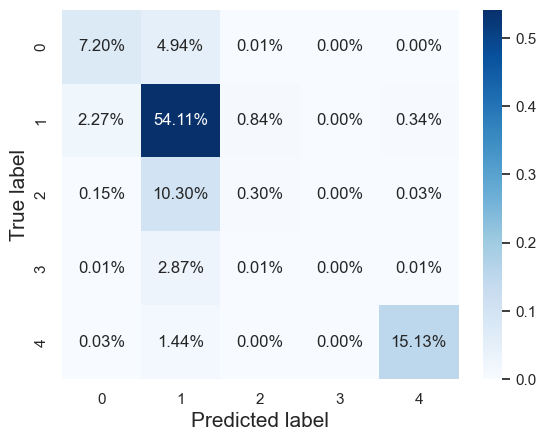

LogisticRegression: Accuracy: 76.73716012084593%
LogisticRegression: F1 score: 71.67386317424985%
CPU times: total: 32.7 s
Wall time: 5.59 s


In [56]:
%%time
# CLIENTID based LogisticRegression()
# Choose model
model_init = LogisticRegression(solver = 'lbfgs', random_state=1, max_iter=500)
# Run model
model1 = run_model_categories(clientid_train_df_logistic_x, clientid_train_df_logistic_y, 
                        clientid_validate_df_logistic_x, clientid_validate_df_logistic_y,
                       cont_cols, model_init, "LogisticRegression")

#### AdaBoostClassifier

Balancing classes...
Fitting model...


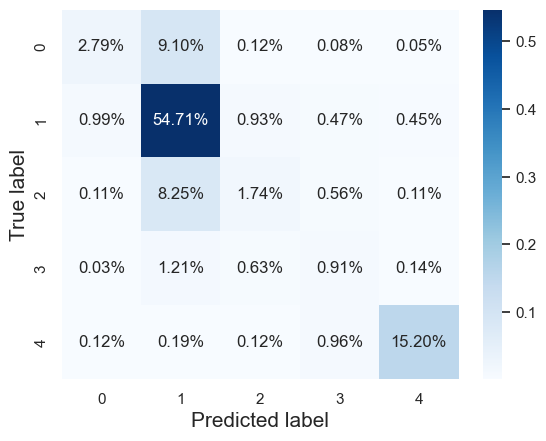

AdaBoostClassifier: Accuracy: 75.35017852238396%
AdaBoostClassifier: F1 score: 71.27108213555442%
CPU times: total: 4.98 s
Wall time: 4.99 s


In [57]:
%%time
# CLIENTID based AdaBoostClassifier()
# Choose model
model_init = AdaBoostClassifier()

# Run model
model2 = run_model_categories(clientid_train_df_logistic_x, clientid_train_df_logistic_y, 
                        clientid_validate_df_logistic_x, clientid_validate_df_logistic_y,
                       cont_cols, model_init, "AdaBoostClassifier")

#### KNeighborsClassifier

Balancing classes...
Fitting model...


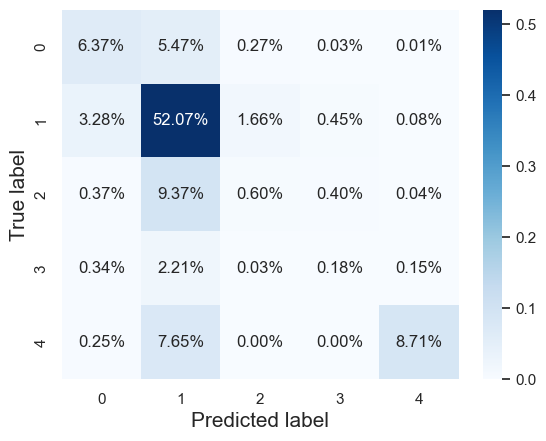

KNeighborsClassifier: Accuracy: 67.93463334248833%
KNeighborsClassifier: F1 score: 63.95961059478874%
CPU times: total: 10.5 s
Wall time: 1.24 s


In [58]:
%%time
# CLIENTID based KNeighborsClassifier()
# Choose model
model_init = KNeighborsClassifier()

# Run model
model3 = run_model_categories(clientid_train_df_logistic_x, clientid_train_df_logistic_y, 
                        clientid_validate_df_logistic_x, clientid_validate_df_logistic_y,
                       cont_cols, model_init, "KNeighborsClassifier")

#### BaggingClassifier

Balancing classes...
Fitting model...


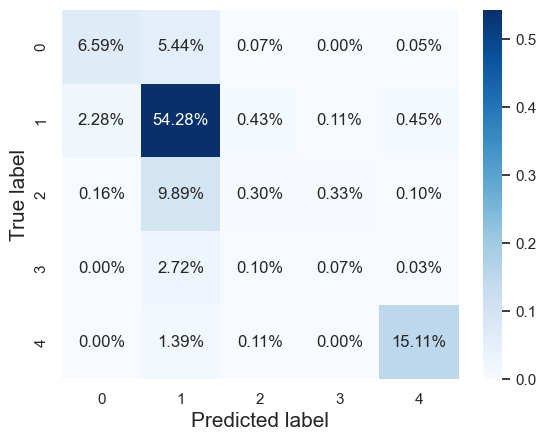

BaggingClassifier+KNeighborsClassifier: Accuracy: 76.35265037077727%
BaggingClassifier+KNeighborsClassifier: F1 score: 71.34138801619679%
CPU times: total: 24.9 s
Wall time: 2.57 s


In [59]:
%%time
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

# CLIENTID based BaggingClassifier()
# Choose model
model_init = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=50), n_estimators=3, max_samples=0.8)

# Run model
model4 = run_model_categories(clientid_train_df_logistic_x, clientid_train_df_logistic_y, 
                        clientid_validate_df_logistic_x, clientid_validate_df_logistic_y,
                       cont_cols, model_init, "BaggingClassifier+KNeighborsClassifier")

#### XGBoost

Balancing classes...
Fitting model...


C:\Users\ktlil\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


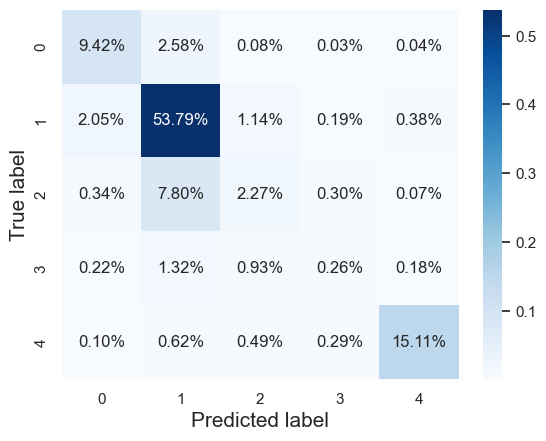

XGBoost: Accuracy: 80.84317495193628%
XGBoost: F1 score: 78.48383242841967%
CPU times: total: 2min 46s
Wall time: 14.6 s


In [60]:
%%time
#XGBoost
# Run model
model5 = run_model_xgb(clientid_train_df_logistic_x, clientid_train_df_logistic_y, 
                        clientid_validate_df_logistic_x, clientid_validate_df_logistic_y,
                       cont_cols, "XGBoost", False)